# Part 3: Ranking & Filtering

In [1]:
import sys
sys.path.append("../IRWA-2025-part-2/")

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

import scipy, scipy.linalg
if not hasattr(scipy.linalg, "triu"):
    scipy.linalg.triu = np.triu

import importlib
import adv_ranking
from indexing import Indexing

from gensim.models import Word2Vec

importlib.reload(adv_ranking)
from adv_ranking import AdvancedRanking

[nltk_data] Downloading package punkt to /Users/chris/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package stopwords to /Users/chris/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


In [2]:
TOPK = 5

In [3]:
def print_rankings(scores, documents, queries, topK=TOPK):
    for qid, q_text in queries.items():
        print(f"\n=== {qid}: {q_text} ===")
        doc_scores = scores.get(qid, {})
        if not doc_scores:
            print("  (no results)")
            continue

        for i, (pid, score) in enumerate(doc_scores.items(), start=1):
            if i > topK:
                break
            print(f"{i:02d}. {pid}  |  {score:.4f}")

In [4]:
def plot_rank_comparison(comp, qid, topK=TOPK):
    """
    comp debe contener: doc, tfidf_rank, bm25_rank, own_rank.
    """
    comp_plot = comp.head(topK).copy()
    comp_plot.index = range(1, len(comp_plot) + 1)

    plt.figure(figsize=(10, 5))

    # plot lines (lower rank = better)
    plt.plot(comp_plot.index, comp_plot["tfidf_rank"], label="TF-IDF", marker="o")
    plt.plot(comp_plot.index, comp_plot["bm25_rank"],  label="BM25",   marker="o")
    plt.plot(comp_plot.index, comp_plot["own_rank"],   label="OwnScore", marker="o")

    plt.gca().invert_yaxis() # rank 1 above, high rank below

    plt.title(f"Rank Comparison (query = {queries[qid]})")
    plt.xlabel("Document Position (Top-K)")
    plt.ylabel("Rank Value (lower = better)")
    plt.legend()
    plt.grid(True)
    plt.show()

In [5]:
def build_comp_for_qid(qid):
    comp = pd.DataFrame({
        "doc": list(scores_tfidf_and[qid].keys()),
        "tfidf_rank": range(1, len(scores_tfidf_and[qid])+1),
        "tfidf_score": list(scores_tfidf_and[qid].values())
    })

    comp = comp.merge(
        pd.DataFrame({
            "doc": list(scores_bm25_and[qid].keys()),
            "bm25_rank": range(1, len(scores_bm25_and[qid])+1),
            "bm25_score": list(scores_bm25_and[qid].values())
        }),
        on="doc", how="outer"
    )

    comp = comp.merge(
        pd.DataFrame({
            "doc": list(scores_own[qid].keys()),
            "own_rank": range(1, len(scores_own[qid])+1),
            "own_score": list(scores_own[qid].values())
        }),
        on="doc", how="outer"
    )
    return comp

In [6]:
# load data
DATA_PATH = "../IRWA-2025-data/fashion_products_dataset_processed.csv"

df = pd.read_csv(DATA_PATH)
df["pid"] = df["pid"].astype(str) # pid as string

In [7]:
documents = pd.Series(df["document"].values, index=df["pid"]) # doc vectors = pid, doc
queries = pd.Series(
    {
        "q1": "women full sleeve sweatshirt cotton",
        "q2": "men slim jeans blue",
        "q3": "women cotton trackpant",
        "q4": "men running shoes",
        "q5": "women printed kurta"
    }
) # test queries

In [8]:
# build inverted index
indexer = Indexing(documents=df, identifier_column="pid", text_column="document")
indexer.build_inverted_index()

{'yorker': ['TKPFCZ9EA7H5FYZH',
  'TKPFCZ9EJZV2UVRZ',
  'TKPFCZ9EHFCY5Z4Y',
  'TKPFCZ9ESZZ7YWEF',
  'TKPFCZ9EVXKBSUD7',
  'TKPFCZ9EFK9DNWDA',
  'TKPFDABN3GXYPFHE',
  'TKPFCZ9ESGZYT8NH',
  'TKPFCZ9DYU33FFXS',
  'TKPFDABN4NQFVKZY',
  'TKPFCZ9ENWGMX23W',
  'TKPFCZ9EHCNAPKPU',
  'TKPFDACEXAWUHGR7',
  'TKPFCZ9ETR6YVXNG',
  'TKPFD3K6K5TNYZGF',
  'TKPFCZ9EGGYENTZS',
  'TKPFD3K6ZMN79MPH',
  'TKPFD3K6UZBYDZNY',
  'TKPFD3K62JB9PEMR',
  'TKPFCZ9EZDPZR5AH',
  'TKPFCZ9EVM2GZ4GF',
  'TKPFCZ9E2UC3DR3F',
  'TKPFCZ9ECDYYDNKA'],
 'bottomwear': ['TKPFCZ9EA7H5FYZH',
  'TKPFCZ9EJZV2UVRZ',
  'TKPFCZ9EHFCY5Z4Y',
  'TKPFCZ9ESZZ7YWEF',
  'TKPFCZ9EVXKBSUD7',
  'TKPFCZ9EFK9DNWDA',
  'TKPFDABN3GXYPFHE',
  'TKPFCZ9ESGZYT8NH',
  'TKPFCZ9DYU33FFXS',
  'TKPFDABN4NQFVKZY',
  'TKPFCZ9ENWGMX23W',
  'TKPFZFSHHACG3FHC',
  'TKPFZFSHQPDRGZTM',
  'TKPFZ4YTRF3ZRTTH',
  'TKPFZ4YTJZWBFYFZ',
  'TKPFZFSH3F9ZA7C6',
  'TKPFZ4YT7ZNYXG27',
  'TKPFZ4YTGNZJDZDU',
  'TKPFZ4YTX94CY9JX',
  'TKPFCZ9EHCNAPKPU',
  'TKPFDACEXAWUHGR7',
  'TKPF

In [9]:
# ranking object
ranker = AdvancedRanking(documents=documents, queries=queries, indexer=indexer)

## 1.

You’re asked to provide 3 different ways of ranking:

- TF-IDF + cosine similarity: Classical scoring, which we have also seen during the practical labs.
- BM25.
- Your Score: Here, the task is to create a new score. (Be creative 🎨, think about what factors could make a document more relevant to a query and include them in your formula.)

In [10]:
# 1a. TF-IDF + AND
scores_tfidf_and = ranker.rank_tfidf_and(topK=TOPK)
print_rankings(scores_tfidf_and, documents, queries, topK=TOPK)


=== q1: women full sleeve sweatshirt cotton ===
01. SWSFHX43ZEH8BJGC  |  0.5314
02. SWSFM2W3RHVCRSM5  |  0.5289
03. SWSFUFGUVJE36XAH  |  0.5289
04. SWSFZVTTQCB4SJ7F  |  0.4819
05. SWSFUY89FZBPHHFK  |  0.4810

=== q2: men slim jeans blue ===
01. JEAFSGSYEAFCYHEE  |  0.4008
02. JEAFTGSGTYKZGAEZ  |  0.4008
03. JEAFRAQXEKGUPNUN  |  0.3626
04. JEAF65G3GPYHV7XW  |  0.3559
05. JEAFEKQZ4C2Z6GCX  |  0.3216

=== q3: women cotton trackpant ===
01. TKPFZG7YWKYWSZ2P  |  0.3717
02. TKPFWUYHHBZYBJ36  |  0.2844
03. TKPFX8WJRUKHMCKX  |  0.2778
04. TKPFHEYEYB3VXTEC  |  0.2701
05. TKPFYVRN3ZZZGAPH  |  0.2569

=== q4: men running shoes ===
01. SHOEP5GUQYYFKYSN  |  0.0693
02. SHOESS9ZEZ6TEQUJ  |  0.0690
03. SHOESS9ZGMH7CURM  |  0.0690
04. SHOFTZFPNCU4VWHK  |  0.0683
05. SHOFTZFQP8W9G86F  |  0.0682

=== q5: women printed kurta ===
01. KTAFZCK5RGNECHHH  |  0.2624
02. KTAFZCH5954HZSWJ  |  0.2608
03. KTAFZCH5BCNAFZJ6  |  0.2608
04. KTAFZCK5DPNRZXHZ  |  0.2518
05. KTAFZCK5XEZCZXF8  |  0.2518


In [11]:
# 1b. BM25 + AND
scores_bm25_and = ranker.rank_bm25_and(topK=TOPK)
print_rankings(scores_bm25_and, documents, queries, topK=TOPK)


=== q1: women full sleeve sweatshirt cotton ===
01. SWSFHX43ZEH8BJGC  |  9.8127
02. SWSFM2W3RHVCRSM5  |  9.8127
03. SWSFNZQGKRG37WHK  |  9.8127
04. SWSFQGS456JAZCQB  |  9.8127
05. SWSFUFGUVJE36XAH  |  9.8127

=== q2: men slim jeans blue ===
01. JEAFSGSYEAFCYHEE  |  7.9549
02. JEAFTGSGTYKZGAEZ  |  7.9549
03. JEAFESND4QWQUBZD  |  7.8252
04. JEAFESNEYAHAGPNH  |  7.8252
05. JEAFJV3HMBB9YA7G  |  7.8252

=== q3: women cotton trackpant ===
01. TKPFZG7YWKYWSZ2P  |  10.9219
02. TKPFWUYHHBZYBJ36  |  10.5925
03. TKPFYVRN3ZZZGAPH  |  10.1342
04. TKPFW8RZUHTHEHMH  |  9.5814
05. TKPFV4MTHHV7VXAY  |  9.4525

=== q4: men running shoes ===
01. SHOESS9ZEZ6TEQUJ  |  1.4590
02. SHOESS9ZGMH7CURM  |  1.4590
03. SHOEWQKVSGFGXPQF  |  1.4590
04. SHOFTZFPNCU4VWHK  |  1.4590
05. SHOFTZFQQYKC8HY6  |  1.4590

=== q5: women printed kurta ===
01. FABFWN82HVT5KAH2  |  7.2163
02. DHTFVSYYGRARRTYY  |  6.7876
03. ETHFT9HQNKWEF2EH  |  6.7876
04. ETHFT9HQRGEXHETK  |  6.7876
05. ETHFT9HQDDYTZZT5  |  6.6883


In [12]:
# 1c. own score
ranker.set_metadata(df, id_column="pid") # same df used for documents, with rating and discount columns
scores_own = ranker.rank_own_from_tfidf_and(topK=TOPK)
print_rankings(scores_own, documents, queries, topK=TOPK)


=== q1: women full sleeve sweatshirt cotton ===
01. SWSFHX43ZEH8BJGC  |  0.5800
02. SWSFM2W3RHVCRSM5  |  0.5792
03. SWSFUFGUVJE36XAH  |  0.5782
04. SWSFUY89FZBPHHFK  |  0.5327
05. SWSFZVTTQCB4SJ7F  |  0.3573

=== q2: men slim jeans blue ===
01. JEAFEKQZ4C2Z6GCX  |  0.4291
02. JEAF65G3GPYHV7XW  |  0.4212
03. JEAFSGSYEAFCYHEE  |  0.3275
04. JEAFTGSGTYKZGAEZ  |  0.3005
05. JEAFRAQXEKGUPNUN  |  0.2738

=== q3: women cotton trackpant ===
01. TKPFZG7YWKYWSZ2P  |  0.4622
02. TKPFWUYHHBZYBJ36  |  0.4331
03. TKPFHEYEYB3VXTEC  |  0.4270
04. TKPFX8WJRUKHMCKX  |  0.3975
05. TKPFYVRN3ZZZGAPH  |  0.3078

=== q4: men running shoes ===
01. SHOFTZFQP8W9G86F  |  0.2767
02. SHOFTZFPNCU4VWHK  |  0.2738
03. SHOESS9ZEZ6TEQUJ  |  0.2293
04. SHOEP5GUQYYFKYSN  |  0.2215
05. SHOESS9ZGMH7CURM  |  0.2053

=== q5: women printed kurta ===
01. KTAFZCK5RGNECHHH  |  0.4217
02. KTAFZCH5954HZSWJ  |  0.4206
03. KTAFZCH5BCNAFZJ6  |  0.4206
04. KTAFZCK5DPNRZXHZ  |  0.4142
05. KTAFZCK5XEZCZXF8  |  0.4142


In [13]:
for qid in queries.index:
    print(f"\n=== Comparison for {qid} ({queries[qid]}) ===\n")

    comp = pd.DataFrame({
        "doc": list(scores_tfidf_and[qid].keys()),
        "tfidf_rank": range(1, len(scores_tfidf_and[qid])+1),
        "tfidf_score": list(scores_tfidf_and[qid].values())
    })

    comp = comp.merge(
        pd.DataFrame({
            "doc": list(scores_bm25_and[qid].keys()),
            "bm25_rank": range(1, len(scores_bm25_and[qid])+1),
            "bm25_score": list(scores_bm25_and[qid].values())
        }),
        on="doc", how="outer"
    )

    comp = comp.merge(
        pd.DataFrame({
            "doc": list(scores_own[qid].keys()),
            "own_rank": range(1, len(scores_own[qid])+1),
            "own_score": list(scores_own[qid].values())
        }),
        on="doc", how="outer"
    )

    # añadir texto del documento (recortado)
    comp["text"] = comp["doc"].map(documents).str[:120] + "..."

    display(comp.head(10))


=== Comparison for q1 (women full sleeve sweatshirt cotton) ===



doc  tfidf_rank  tfidf_score  bm25_rank  bm25_score  own_rank  \
0  SWSFHX43ZEH8BJGC         1.0     0.531384        1.0      9.8127       1.0   
1  SWSFM2W3RHVCRSM5         2.0     0.528902        2.0      9.8127       2.0   
2  SWSFNZQGKRG37WHK         NaN          NaN        3.0      9.8127       NaN   
3  SWSFQGS456JAZCQB         NaN          NaN        4.0      9.8127       NaN   
4  SWSFUFGUVJE36XAH         3.0     0.528902        5.0      9.8127       3.0   
5  SWSFUY89FZBPHHFK         5.0     0.481031        NaN         NaN       4.0   
6  SWSFZVTTQCB4SJ7F         4.0     0.481885        NaN         NaN       5.0   

   own_score                                               text  
0     0.5800  wash women sweatshirt solid pu blend wear cott...  
1     0.5792  wash women print sweatshirt pu blend wear cott...  
2        NaN  blend women sweatshirt wash okan cotton wear w...  
3        NaN  wash women print sweatshirt blend cotton wear ...  
4     0.5782  wash women print sweatshirt pu blend wear cott...  
5     0.5327  retailnet wash women sweatshirt solid pu blend...  
6     0.3573  wash women sweatshirt solid blend cotton wear ...


=== Comparison for q2 (men slim jeans blue) ===



doc  tfidf_rank  tfidf_score  bm25_rank  bm25_score  own_rank  \
0  JEAF65G3GPYHV7XW         4.0     0.355940        NaN         NaN       2.0   
1  JEAFEKQZ4C2Z6GCX         5.0     0.321621        NaN         NaN       1.0   
2  JEAFESND4QWQUBZD         NaN          NaN        3.0      7.8252       NaN   
3  JEAFESNEYAHAGPNH         NaN          NaN        4.0      7.8252       NaN   
4  JEAFJV3HMBB9YA7G         NaN          NaN        5.0      7.8252       NaN   
5  JEAFRAQXEKGUPNUN         3.0     0.362635        NaN         NaN       5.0   
6  JEAFSGSYEAFCYHEE         1.0     0.400785        1.0      7.9549       3.0   
7  JEAFTGSGTYKZGAEZ         2.0     0.400785        2.0      7.9549       4.0   

   own_score                                               text  
0     0.4212  accessori wash blend cotton slim bottomwear so...  
1     0.4291  true accessori blend cotton slim bottomwear bl...  
2        NaN  true accessori slim bottomwear bl western clot...  
3        NaN  true accessori slim bottomwear bl western clot...  
4        NaN  accessori cotton slim dark bottomwear western ...  
5     0.2738  accessori wash blend cotton slim bottomwear we...  
6     0.3275  accessori blend cotton slim bottomwear western...  
7     0.3005  accessori blend cotton slim bottomwear western...


=== Comparison for q3 (women cotton trackpant) ===



doc  tfidf_rank  tfidf_score  bm25_rank  bm25_score  own_rank  \
0  TKPFHEYEYB3VXTEC         4.0     0.270054        NaN         NaN       3.0   
1  TKPFV4MTHHV7VXAY         NaN          NaN        5.0      9.4525       NaN   
2  TKPFW8RZUHTHEHMH         NaN          NaN        4.0      9.5814       NaN   
3  TKPFWUYHHBZYBJ36         2.0     0.284399        2.0     10.5925       2.0   
4  TKPFX8WJRUKHMCKX         3.0     0.277796        NaN         NaN       4.0   
5  TKPFYVRN3ZZZGAPH         5.0     0.256891        3.0     10.1342       5.0   
6  TKPFZG7YWKYWSZ2P         1.0     0.371712        1.0     10.9219       1.0   

   own_score                                               text  
0     0.4270  mc colour waist elast green cotton bottomwear ...  
1        NaN  level well cotton solid bottomwear cloth track...  
2        NaN  busi cotton bottomwear cloth trackpant stripe ...  
3     0.4331  grey women cotton color bottomwear track cloth...  
4     0.3975  cotton solid bottomwear cloth trackpant stylis...  
5     0.3078  unlimit llp drawstf cotton solid bottomwear cl...  
6     0.4622  blend women cotton bottomwear track cloth bind...


=== Comparison for q4 (men running shoes) ===



doc  tfidf_rank  tfidf_score  bm25_rank  bm25_score  own_rank  \
0  SHOEP5GUQYYFKYSN         1.0     0.069265        NaN         NaN       4.0   
1  SHOESS9ZEZ6TEQUJ         2.0     0.069049        1.0       1.459       3.0   
2  SHOESS9ZGMH7CURM         3.0     0.069049        2.0       1.459       5.0   
3  SHOEWQKVSGFGXPQF         NaN          NaN        3.0       1.459       NaN   
4  SHOFTZFPNCU4VWHK         4.0     0.068330        4.0       1.459       2.0   
5  SHOFTZFQP8W9G86F         5.0     0.068155        NaN         NaN       1.0   
6  SHOFTZFQQYKC8HY6         NaN          NaN        5.0       1.459       NaN   

   own_score                                               text  
0     0.2215  run soccerintern women footwear shoe white men...  
1     0.2293  run soccerintern footwear shoe men vector mult...  
2     0.2053  run soccerintern footwear shoe men vector mult...  
3        NaN    forbeskart run footwear shoe men blue vector...  
4     0.2738     run bone footwear shoe manojsunda men black...  
5     0.2767  run women bone footwear shoe manojsunda men bl...  
6        NaN    run yellow bone footwear shoe manojsunda men...


=== Comparison for q5 (women printed kurta) ===



doc  tfidf_rank  tfidf_score  bm25_rank  bm25_score  own_rank  \
0  DHTFVSYYGRARRTYY         NaN          NaN        2.0      6.7876       NaN   
1  ETHFT9HQDDYTZZT5         NaN          NaN        5.0      6.6883       NaN   
2  ETHFT9HQNKWEF2EH         NaN          NaN        3.0      6.7876       NaN   
3  ETHFT9HQRGEXHETK         NaN          NaN        4.0      6.7876       NaN   
4  FABFWN82HVT5KAH2         NaN          NaN        1.0      7.2163       NaN   
5  KTAFZCH5954HZSWJ         2.0     0.260793        NaN         NaN       2.0   
6  KTAFZCH5BCNAFZJ6         3.0     0.260793        NaN         NaN       3.0   
7  KTAFZCK5DPNRZXHZ         4.0     0.251765        NaN         NaN       4.0   
8  KTAFZCK5RGNECHHH         1.0     0.262428        NaN         NaN       1.0   
9  KTAFZCK5XEZCZXF8         5.0     0.251765        NaN         NaN       5.0   

   own_score                                               text  
0        NaN  bottom cotton floral cloth set prnt women ethn...  
1        NaN  bottom cotton cloth set blend women ethnic eno...  
2        NaN  bottom cotton cloth set falsa blend women ethn...  
3        NaN  bottom cotton cloth set blend women ethnic eno...  
4        NaN  fabric unstitch wash women cotton print djuiz ...  
5     0.4206  apparel bottom cotton cloth full white set reg...  
6     0.4206  apparel bottom cotton cloth full white set reg...  
7     0.4142  apparel bottom cotton cloth full set beig regu...  
8     0.4217  apparel bottom cotton cloth full set regular b...  
9     0.4142  apparel bottom cotton cloth full set beig regu...


=== Plot for query q1: women full sleeve sweatshirt cotton ===


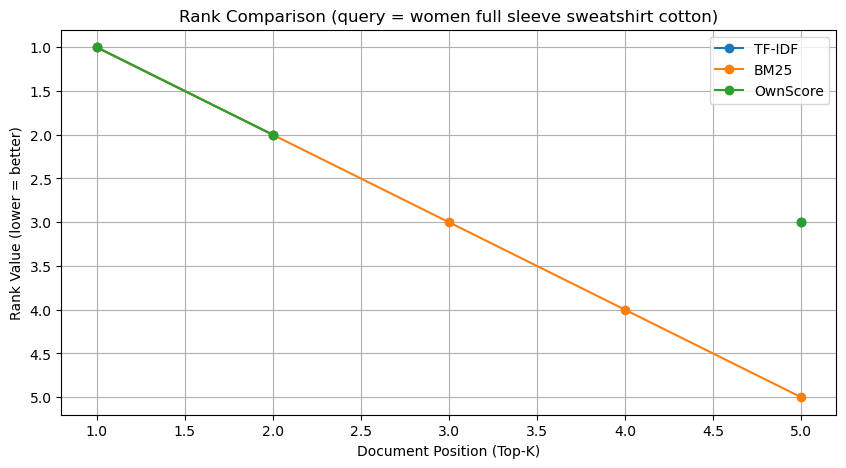


=== Plot for query q2: men slim jeans blue ===


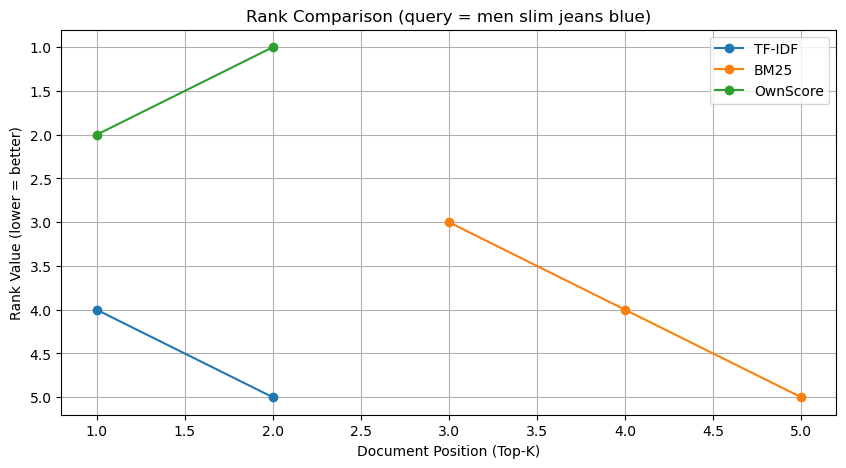


=== Plot for query q3: women cotton trackpant ===


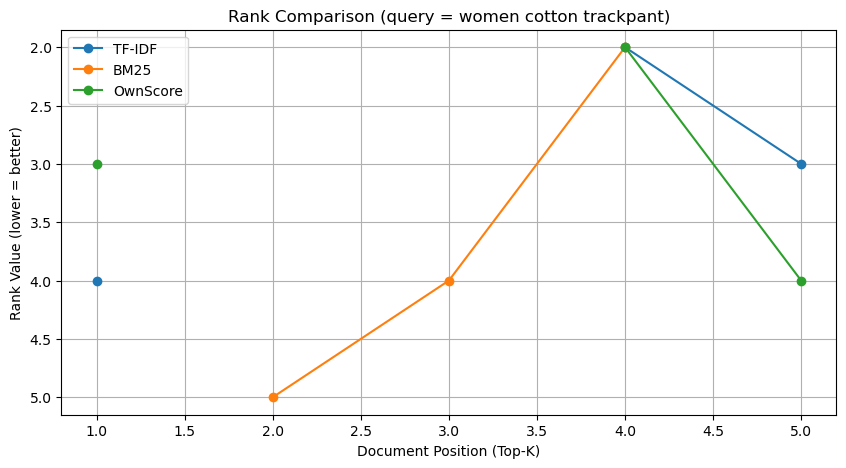


=== Plot for query q4: men running shoes ===


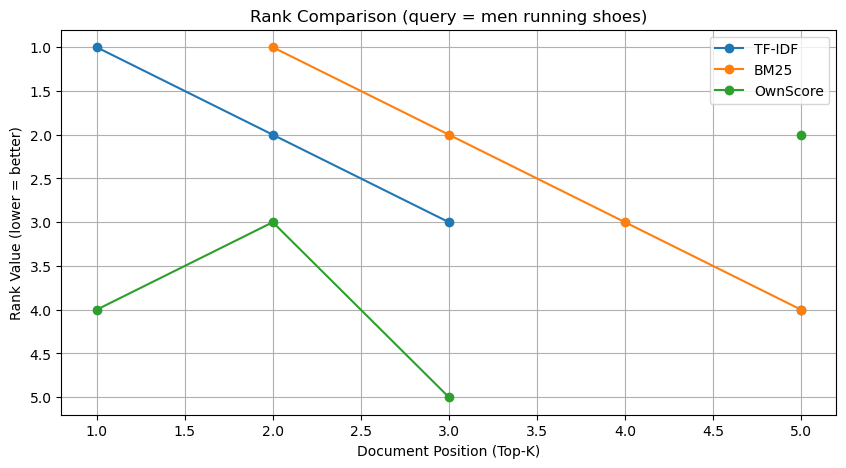


=== Plot for query q5: women printed kurta ===


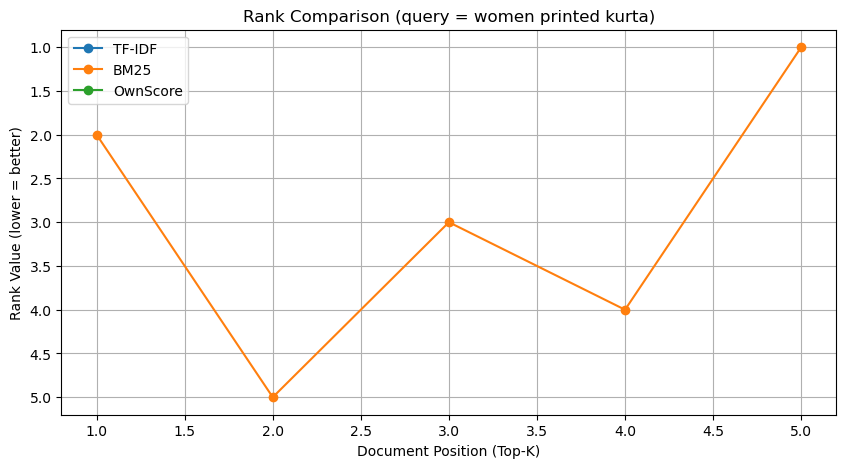

In [14]:
for qid in queries.index:
    print(f"\n=== Plot for query {qid}: {queries[qid]} ===")
    comp = build_comp_for_qid(qid)
    
    if comp.empty:
        print("⚠️ No results for this query (AND filtering too strict).")
        continue
    
    plot_rank_comparison(comp, qid)

Explain how the ranking differs when using TF-IDF and BM25, and think about the pros
and cons of using each of them. Regarding your own score, justify the choice of the
score (pros and cons). HINT: Look into numerical fields that each record has to build your
score.

**Answer:**

Al comparar TF-IDF y BM25, la diferencia principal está en cómo interpretan la relevancia del texto.
TF-IDF funciona bien midiendo similitud, pero suele tratar igual a documentos largos y cortos, y a veces diluye la importancia de los términos si el documento tiene demasiado contenido. BM25 corrige esto: controla mejor la frecuencia de las palabras y ajusta por la longitud del documento, por lo que suele dar resultados más “realistas” en búsquedas. En nuestros gráficos se nota que BM25 ordena los documentos de forma más marcada, mientras que TF-IDF es más estable pero menos agresivo.

Para mi OwnScore, mezclé la parte textual (TF-IDF) con dos variables del producto: rating y descuento. La idea es que, además de ser relevante por texto, un producto “bueno” o con un descuento interesante también suba posiciones. La ventaja es que se adapta mejor a un caso de uso tipo e-commerce; la desventaja es que introduce cierta subjetividad porque depende de los pesos que yo mismo asigno, y puede favorecer demasiado a productos con descuento aunque no sean tan relevantes textualmente.

## 2.

In [15]:
# 2. word2vec
sentences = [str(text).split() for text in df["document"]]

w2v_model = Word2Vec(
    sentences,
    vector_size=50,
    window=5,
    min_count=2,
    workers=4,
    sg=0
)

w2v = w2v_model.wv # word vectors

In [16]:
# build documents
df["pid"] = df["pid"].astype(str)
documents = pd.Series(df["document"].values, index=df["pid"])

# indexer
indexer = Indexing(df, identifier_column="pid", text_column="document")
indexer.build_inverted_index()

# ranker
ranker = AdvancedRanking(documents=documents, queries=queries, indexer=indexer)

In [17]:
scores_w2v = ranker.rank_w2v_and(w2v, topK=TOPK)
print_rankings(scores_w2v, documents, queries, topK=TOPK)


=== q1: women full sleeve sweatshirt cotton ===
01. SWSFWDYH2C4HYAUJ  |  0.8369
02. SWSFWDYHH6PK6JYA  |  0.8329
03. SWSEP4DJBZWHAZXC  |  0.8018
04. SWSEP4EBPJYA6G2S  |  0.8018
05. SWSF8922JQNQQHVG  |  0.7978

=== q2: men slim jeans blue ===
01. JEAFGJ9Y9QKCYA6J  |  0.8456
02. JEAFV8WURBM7PGYT  |  0.8251
03. JEAFS57EYDGY4EJM  |  0.8239
04. JEAFJV3HMBB9YA7G  |  0.8215
05. JEAFESNEYAHAGPNH  |  0.8188

=== q3: women cotton trackpant ===
01. TKPFZG7YWKYWSZ2P  |  0.6986
02. TKPFW8RZUHTHEHMH  |  0.6660
03. TKPFYVRN3ZZZGAPH  |  0.6574
04. TKPFHEYEYB3VXTEC  |  0.6460
05. TKPF7NWYBMP8GARX  |  0.6000

=== q4: men running shoes ===
01. SHOEYF5UHUUH5ADZ  |  0.5557
02. SHOEKNRJGEYJCDQK  |  0.5123
03. SHOEWQKVSGFGXPQF  |  0.4956
04. SHOFN3EFNYGBKZT7  |  0.4876
05. SHOESS9ZEZ6TEQUJ  |  0.4795

=== q5: women printed kurta ===
01. ETHFT9HQRGEXHETK  |  0.8456
02. DHTFVSYYGRARRTYY  |  0.8448
03. ETHFT9HQDDYTZZT5  |  0.8393
04. ETHFT9HQNKWEF2EH  |  0.8385
05. ETHFY7FBXY6ZDTKN  |  0.7990


Para representar cada documento y cada query con Word2Vec, primero obtenemos el vector Word2Vec de cada palabra del texto y después calculamos la media de esos vectores. Esto produce un único vector que resume el contenido del documento. Finalmente, comparamos los vectores de documento y query mediante cosine similarity, lo que nos permite obtener un ranking basado en significado semántico y no solo en coincidencias exactas de términos.

## 3.

Can you imagine a better representation than word2vec? Justify your answer.
(HINT - what about Doc2vec? Sentence2vec? What are the pros and cons?)

**Answer:**

Word2Vec funciona, pero pierde parte del significado del texto al promediar los vectores de palabras. Una representación mejor sería Doc2Vec, que aprende un vector específico para cada documento y captura mejor el contexto completo. También modelos como Sentence2Vec o representaciones basadas en BERT ofrecen resultados superiores al tener en cuenta la estructura y el significado global del texto. Estas alternativas suelen proporcionar una similitud semántica más precisa que Word2Vec.